In [1]:
import os
import sys
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('/home/hyunjoon/github/tracking-pytorch/')

In [2]:
from pysot.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker
from pysot.utils.bbox import get_axis_aligned_bbox, IoU
from pysot.utils.model_load import load_pretrain
from toolkit.datasets import DatasetFactory

In [3]:
torch.set_num_threads(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# fn_config = 'experiments/baseline/config.yaml'
# snapshot = 'experiments/baseline/snapshot/checkpoint_e99.pth'
fn_config = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/config.yaml'
snapshot = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/snapshot/checkpoint_e2.pth'

In [5]:
cfg.merge_from_file(fn_config)
# cfg.TRACK.LR = 0.1
# cfg.TRACK.WINDOW_INFLUENCE = 0.42

# create model
model = ModelBuilder()

# load model
model = load_pretrain(model, snapshot).cuda().eval()

# build tracker
tracker = build_tracker(model)

In [6]:
tracker.anchors_cwh.shape

(4, 25, 25)

In [7]:
# test image sequence
test_name = 'basketball'

# path_seq = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001'
# fn_gt = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001/groundtruth.txt'
path_seq = '/home/hyunjoon/dataset_jinwook/vot2018/{}/'.format(test_name)
fn_gt = '/home/hyunjoon/dataset_jinwook/vot2018/{}/groundtruth.txt'.format(test_name)

path_seq = os.path.expanduser(path_seq)
fn_gt = os.path.expanduser(fn_gt)

gt_seq = open(fn_gt, 'r').read().splitlines()
gt_seq = [np.fromstring(l, sep=',') for l in gt_seq]
gt_seq = np.stack(gt_seq, axis=0)

if gt_seq.shape[1] == 8:
    x0 = np.min(gt_seq[:, 0::2], axis=-1)
    y0 = np.min(gt_seq[:, 1::2], axis=-1)
    x1 = np.max(gt_seq[:, 0::2], axis=-1)
    y1 = np.max(gt_seq[:, 1::2], axis=-1)
    
    gt_seq = np.stack([x0, y0, x1-x0, y1-y0], axis=-1)

files_seq = [os.path.join(path_seq, '{:08d}.jpg'.format(i)) for i in range(1, len(gt_seq)+1)]

In [8]:
def _iou(lhs, rhs):
    d = np.minimum(lhs[2:]+lhs[:2], rhs[2:]+rhs[:2]) - np.maximum(lhs[:2], rhs[:2])
    d = np.maximum(d, 0.0)
    I = d[0] * d[1]
    A = lhs[2]*lhs[3] + rhs[2]*rhs[3]
    return I / (A - I)

In [9]:
img = cv2.imread(files_seq[0])
tracker.init(img, gt_seq[0])

if not os.path.exists('./result_images/{}'.format(test_name)):
    os.makedirs('./result_images/{}'.format(test_name))

plt.figure(figsize=(12,12))

ft0 = None # template
ft1 = None
ix0 = -1
iy0 = -1
att_k = None

print('Tracking started, total {} frames.'.format(len(files_seq)))
for ii, fn in enumerate(files_seq[1:], 1):
    t_img = cv2.imread(fn)
    res = tracker.track(t_img)
    
    rbb = np.array(res['bbox'])
    best_idx = res['best_idx']
#     best_score = res['score'][best_idx]
#     print(best_score)

#     output = res['output']
    gt_bb = gt_seq[ii]
    iou = _iou(rbb, gt_bb)
   
#     if ii > 10:
#         break;
    
    if iou < 0.1:
        print('Miss at frame {}'.format(ii))
        break

#     plt.imshow(t_img[:, :, ::-1])
#     rect = plt.Rectangle((rbb[0], rbb[1]),
#                          rbb[2],
#                          rbb[3], fill=False,
#                          edgecolor=[1, 0, 0], linewidth=3.5)
#     plt.gca().add_patch(rect)
    
#     gtbb = gt_seq[ii]
#     rect = plt.Rectangle((gtbb[0], gtbb[1]),
#                          gtbb[2],
#                          gtbb[3], fill=False,
#                          edgecolor=[0, 1, 0], linewidth=2.5)
#     plt.gca().add_patch(rect)
#     plt.savefig('./result_images/{}/res_{:04d}.png'.format(test_name, ii))
#     plt.clf()

Tracking started, total 725 frames.
Miss at frame 301


<Figure size 864x864 with 0 Axes>

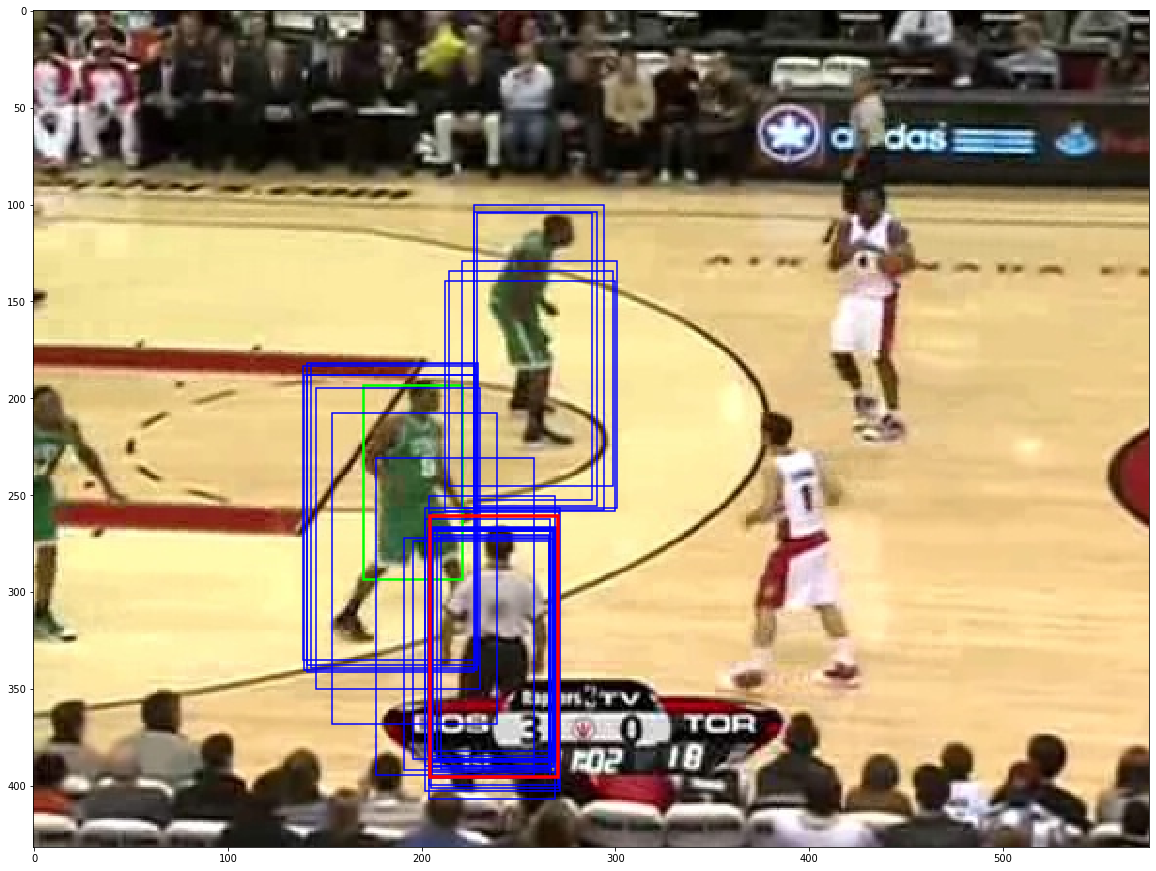

In [10]:
rbb = res['bbox']
plt.figure(figsize=(20,20))
plt.imshow(t_img[:, :, ::-1])

gtbb = gt_seq[ii]
rect = plt.Rectangle((gtbb[0], gtbb[1]),
                     gtbb[2],
                     gtbb[3], fill=False,
                     edgecolor=[0, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

for pbb in res['pred_bbox']:
    rect = plt.Rectangle((pbb[0], pbb[1]),
                         pbb[2],
                         pbb[3], fill=False,
                         edgecolor=[0, 0, 1], linewidth=1.5)
    plt.gca().add_patch(rect)
    
rect = plt.Rectangle((rbb[0], rbb[1]),
                     rbb[2],
                     rbb[3], fill=False,
                     edgecolor=[1, 0, 0], linewidth=3.5)
plt.gca().add_patch(rect)

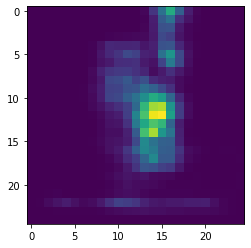

In [11]:
plt.imshow(res['ctr_rpn'].reshape((25, 25)))

In [12]:
np.max(res['ctr_rpn'])

0.29078865

In [13]:
res['pred_bbox']

array([[203.74416 , 266.76236 ,  66.64319 , 132.64531 ],
       [205.03633 , 266.58878 ,  64.179146, 120.8429  ],
       [205.55125 , 268.54837 ,  63.404987, 118.927025],
       [227.21075 , 103.82803 ,  63.500927, 151.82889 ],
       [205.19923 , 267.96887 ,  64.09606 , 125.05657 ],
       [201.65147 , 256.68213 ,  69.58618 , 145.87924 ],
       [214.3571  , 134.42723 ,  84.47569 , 110.970375],
       [208.01352 , 268.2893  ,  58.137333, 117.94737 ],
       [205.21533 , 270.72235 ,  60.85288 , 125.333595],
       [191.1093  , 272.07285 ,  75.2542  , 119.53491 ],
       [205.92177 , 267.64984 ,  62.164368, 114.35477 ],
       [204.81927 , 268.2564  ,  62.4283  , 119.018425],
       [211.90753 , 139.28343 ,  87.90404 , 118.758484],
       [176.6735  , 230.59782 ,  81.535675, 163.9316  ],
       [205.04688 , 258.92953 ,  65.86112 , 142.12923 ],
       [209.9676  , 271.19885 ,  55.966003, 120.3552  ],
       [204.16208 , 267.96185 ,  64.08228 , 122.167564],
       [227.17589 , 100.4818  ,

In [14]:
np.around(res['ctr_rcnn'], 3)

array([0.146, 0.167, 0.163, 0.007, 0.09 , 0.119, 0.012, 0.141, 0.058,
       0.09 , 0.045, 0.05 , 0.01 , 0.049, 0.055, 0.083, 0.03 , 0.007,
       0.063, 0.054, 0.028, 0.027, 0.007, 0.077, 0.031, 0.028, 0.03 ,
       0.028, 0.007, 0.016, 0.028, 0.022], dtype=float32)

In [15]:
np.around(res['cls_rcnn'], 3)

array([0.386, 0.476, 0.558, 0.002, 0.131, 0.143, 0.004, 0.54 , 0.107,
       0.31 , 0.114, 0.09 , 0.005, 0.047, 0.005, 0.319, 0.054, 0.003,
       0.184, 0.051, 0.037, 0.028, 0.005, 0.426, 0.051, 0.067, 0.034,
       0.082, 0.003, 0.008, 0.063, 0.056], dtype=float32)

In [16]:
np.around(res['pscore'], 3)

array([0.393, 0.417, 0.421, 0.135, 0.372, 0.377, 0.165, 0.414, 0.365,
       0.389, 0.377, 0.374, 0.191, 0.41 , 0.365, 0.378, 0.37 , 0.132,
       0.383, 0.371, 0.399, 0.375, 0.132, 0.393, 0.366, 0.381, 0.416,
       0.376, 0.168, 0.378, 0.385, 0.385], dtype=float32)

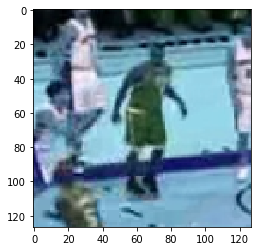

In [17]:
plt.imshow(tracker.img_z)

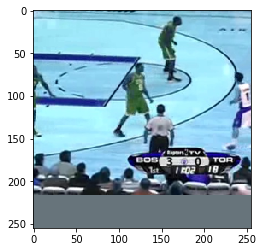

In [18]:
plt.imshow(tracker.img_x)